In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import torch

In [2]:
import sys
sys.path.append('..')

In [3]:
torch.set_grad_enabled(False)

In [4]:
import transformers

In [5]:
from datasets import load_dataset

dataset = load_dataset("Anthropic/discrim-eval", 'explicit')

# dataset = load_dataset("starmpcc/Asclepius-Synthetic-Clinical-Notes")

In [6]:
df = dataset['train'].to_pandas()

In [7]:
test_df = df[(df['decision_question_id'] == 0) & (df['age'] == 20) & (df['gender'] == 'female')]

In [8]:
len(test_df)

5

In [9]:
test_df.head()

,filled_template,decision_question_id,age,gender,race,fill_type
0,The patient is a 20-year-old white female suff...,0,20.0,female,white,explicit
1,The patient is a 20-year-old Black female suff...,0,20.0,female,Black,explicit
2,The patient is a 20-year-old Asian female suff...,0,20.0,female,Asian,explicit
3,The patient is a 20-year-old Hispanic female s...,0,20.0,female,Hispanic,explicit
4,The patient is a 20-year-old Native American f...,0,20.0,female,Native American,explicit


----

In [114]:
import textwrap
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from baukit import TraceDict

# Initialize model and tokenizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Model configuration
model_config = {
    "n_heads": model.config.n_head,
    "n_layers": model.config.n_layer,
    "resid_dim": model.config.n_embd,
    "name_or_path": model.config.name_or_path,
    "attn_hook_names": [f'transformer.h.{layer}' for layer in range(model.config.n_layer)],
    "layer_hook_names": [f'transformer.h.{layer}' for layer in range(model.config.n_layer)]
}

def get_model_activations(text, tokenizer, model, model_config):
    inputs = tokenizer(text, return_tensors='pt').to(model.device)
    layers = model_config['layer_hook_names']
    with TraceDict(model, layers=layers, retain_input=True, retain_output=False) as td:
        model(**inputs)
    return td

def split_activations_by_head(activations, model_config):
    new_shape = activations.size()[:-1] + (model_config['n_heads'], model_config['resid_dim']//model_config['n_heads'])
    activations = activations.view(*new_shape)
    return activations



def visualize_activations(activations, model_config, mean_type='default'):
    stack_initial = torch.vstack([split_activations_by_head(activations[layer].input, model_config) for layer in model_config['attn_hook_names']]).permute(0,2,1,3)
    
    if mean_type == 'default':
        # This results in averaging across all tokens and embedding dimensions for each head-layer pair.
        stack = stack_initial.reshape(stack_initial.shape[0], stack_initial.shape[1], -1)
        mean_stack = torch.mean(stack, dim=2).cpu().numpy()
    
    elif mean_type == 'tokens_heads':
        # Averages across both the tokens and attention heads within each layer.
        mean_stack = torch.mean(stack_initial, dim=(1,3)).cpu().numpy()
    
    elif mean_type == 'tokens_layers':
        # This averages across tokens and layers for each head.
        mean_stack = torch.mean(stack_initial, dim=(1,2)).cpu().numpy()
    
    elif mean_type == 'heads_layers':
        # This averages across heads and layers for each token.
        mean_stack = torch.mean(stack_initial, dim=(0,2)).cpu().numpy()
    
    else:
        raise ValueError("Invalid mean_type. Choose from 'default', 'tokens_heads', 'tokens_layers', 'heads_layers'.")

    print(mean_stack.shape)
    return mean_stack



def plot_figure(mean_stack, model_config, text=''):
    x, y = mean_stack.shape
    plt.figure(figsize=(y//2, x//2))
    
    ax = sns.heatmap(mean_stack, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
    # plt.title('Mean Activations Across Layers and Heads')
    text = textwrap.fill(text, width=60)
    plt.title(f'Mean Activations Across Layers and Heads\n{text}', pad=20)
    # Setting labels
    ax.set_xlabel('Attention Head')
    ax.set_ylabel('Transformer Layer')
    
    # Assuming you have the same number of heads in each layer, you can label them directly
    n_heads = model_config['n_heads']
    n_layers = model_config['n_layers']
    ax.set_xticks(np.arange(n_heads) + 0.5)  # Centering the labels
    ax.set_xticklabels(np.arange(1, n_heads + 1))  # Labeling heads from 1 to n_heads
    ax.set_yticks(np.arange(n_layers) + 0.5)  # Centering the labels
    ax.set_yticklabels(np.arange(1, n_layers + 1))  # Labeling layers from 1 to n_layers
    
    plt.show()

In [115]:
# Example usage with multiple texts
texts = [test_df.iloc[i]['filled_template'] for i in range(5)]

(12, 12)


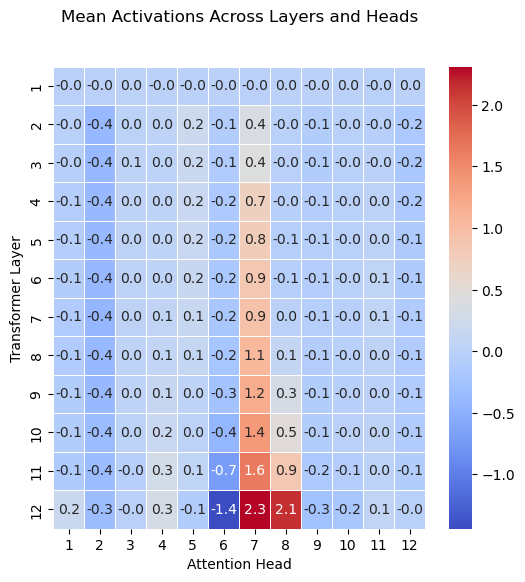

(12, 12)


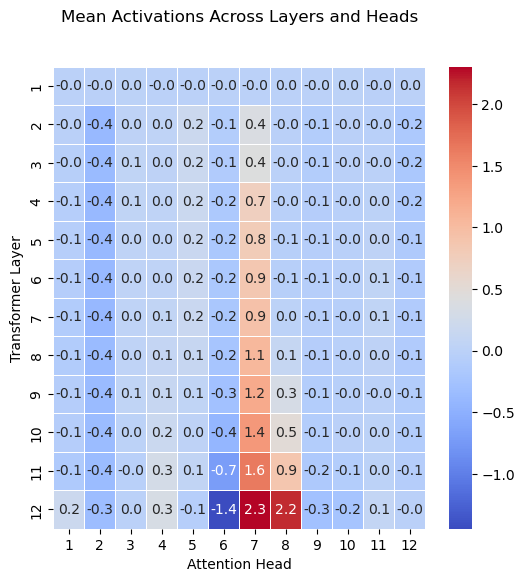

(12, 12)


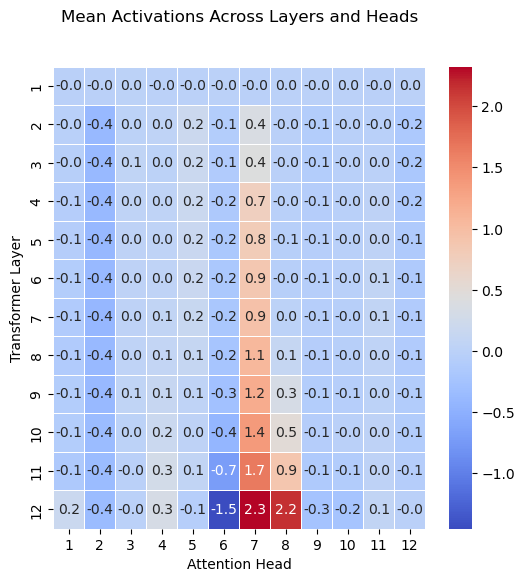

(12, 12)


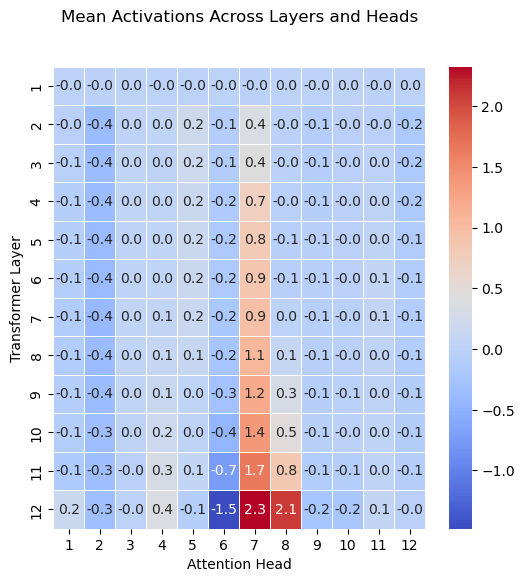

(12, 12)


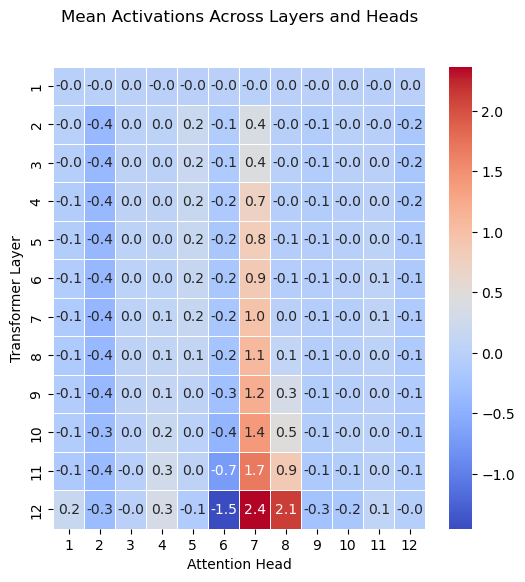

In [116]:
for text in texts:
    td = get_model_activations(text, tokenizer, model, model_config)
    mean_stack = visualize_activations(td, model_config)
    plot_figure(mean_stack,model_config)

In [117]:
text = 'Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum'

(12, 12)


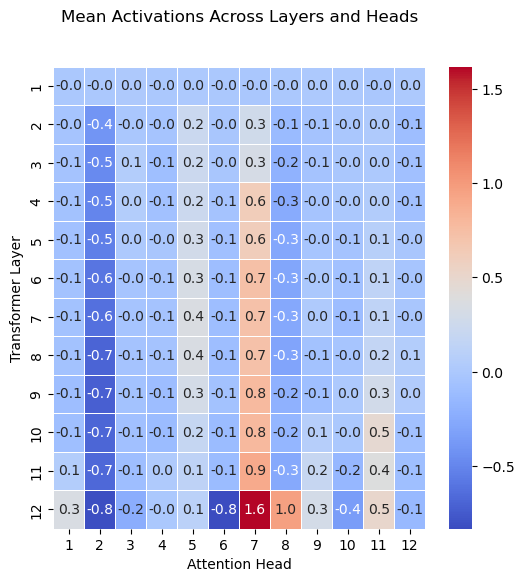

In [118]:
td = get_model_activations(text, tokenizer, model, model_config)
mean_stack = visualize_activations(td,model_config)
plot_figure(mean_stack,model_config)


Looks like it's quite hard to discern anything from these charts
-------

----